In [54]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from skimage import data
from skimage.color import rgb2gray
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from skimage import data, exposure
import pandas as pd
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.optimizers import RMSprop

In [55]:
# Caricamento del Dataset
classesName = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [56]:
# Divisione con insieme di validazione formato dal % del train
percentuale = 0.1
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=percentuale, random_state=1)

In [57]:
# Normalizzazione in 0-1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0

In [58]:
######################################################################################
###################### -- PANDAS DF -- ###############################################
######################################################################################

# Riduzione di dimensionalità x train
##  print(" - Creazione Df x train - ")

# -1 -> numero righe finali impostato in automatico
# 3072 -> numero colonne che deriva da 32*32*3
# - in questo modo ogni riga corrisponde a un'immagine e ogni colonna il valore di un pixel in un'unico canale colore
x_train_flat = x_train.reshape(-1,3072)

# Creazione di una lista di nomi di pixel dal primo all'ultimo che compone un'immagine
# - utile in seguito in modo da assegnare nome a colonne del Data Frame Pandas
feat_cols = ['pixel'+str(i) for i in range(x_train_flat.shape[1])]

# Creazione del dataframe pandas
df_cifar = pd.DataFrame(x_train_flat,columns=feat_cols)

##  print("Shape di df_cifar : ")
##  print(df_cifar.shape)
##  print("")

# Assegnazione delle etichette ai valori nel dataframe
df_cifar['label'] = y_train

##  print("Shape del df_cifar dopo aggiunta etichette : ")
##  print(df_cifar.shape)


###########################
# - Stessa cosa per val - #
###########################

x_val_flat = x_val.reshape(-1,3072)

feat_cols_val = ['pixel'+str(i) for i in range(x_val_flat.shape[1])]

df_cifar_val = pd.DataFrame(x_val_flat,columns=feat_cols_val)

df_cifar_val['label'] = y_val


############################
# - Stessa cosa per test - #
############################

x_test_flat = x_test.reshape(-1,3072)

feat_cols_test = ['pixel'+str(i) for i in range(x_test_flat.shape[1])]

df_cifar_test = pd.DataFrame(x_test_flat,columns=feat_cols_test)

df_cifar_test['label'] = y_test

In [67]:
# Utilizzo di PCA su TRAIN

# n_components è il numero di componenti che vogliamo valutare come obiettivo
##  pca_train = PCA(0.9)
pca_train = PCA(n_components=0.9, copy=True, whiten=False, svd_solver='full', tol=0.0, iterated_power='auto', n_oversamples=10, power_iteration_normalizer='auto', random_state=None)

# Estrazione di tutti i dati tranne ultima colonna che contiene le etichette
# - principalComponents_cifar è il risultato della riduzione di dimensionalità
principalComponents_cifar = pca_train.fit_transform(df_cifar.iloc[:,:-1])


###########################
# Utilizzo di PCA su TEST #
###########################

##  pca_test = PCA(pca_train.n_components_)
pca_test = PCA(n_components=pca_train.n_components_, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', n_oversamples=10, power_iteration_normalizer='auto', random_state=None)

principalComponents_cifar_test = pca_test.fit_transform(df_cifar_test.iloc[:,:-1])


##########################
# Utilizzo di PCA su VAL #
##########################

pca_val = PCA(pca_train.n_components_)
pca_val = PCA(n_components=pca_train.n_components_, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', n_oversamples=10, power_iteration_normalizer='auto', random_state=None)

principalComponents_cifar_val = pca_val.fit_transform(df_cifar_val.iloc[:,:-1])

print("\n Numero caratteristiche individuate in train : ",pca_train.n_components_)

In [ ]:
##  print("Assegnazione nome colonne a DF ottenuto x TRAIN")

# DF = Data Frame

# Creazione di nuovo data frame
# - partendo da quello appena ottenuto
# - vengono aggiunti i nomi dei valori contenuti
pca_cifar_Df = pd.DataFrame(data = principalComponents_cifar)

##  print("")

# Aggiunta della colonna con le etichette dei dati relativi
# - Lo faccio in una copia del dataframe così da averne uno senza etichette
##  print("Creazione dataframe con etichette come ultima colonna")
pca_cifar_Df_con_etichette = pca_cifar_Df.copy()
pca_cifar_Df_con_etichette['y'] = y_train

##  print("")

# - STAMPE DI SERVIZIO - # 
# Stampa del nuovo DF
#print("Shape del DF risultato :")
#print(principal_cifar_Df.shape)

#print("")

# Stampa delle prime righe del DF
#print("Head di principal_cifar_Df : ")
#principal_cifar_Df.head()

#print("Shape del DF_etichettato risultato :")
#print(principal_cifar_Df_con_etichette.shape)

#print("")

# Stampa delle prime righe del DF
#print("Head di principal_cifar_Df_etichettato : ")
#principal_cifar_Df_con_etichette.head()


################################################################################
print("Assegnazione nome colonne a DF ottenuto x TEST")

pca_cifar_Df_test = pd.DataFrame(data = principalComponents_cifar_test)

print("")

print("Creazione dataframe con etichette come ultima colonna x test")
pca_cifar_Df_con_etichette_test = pca_cifar_Df_test.copy()
pca_cifar_Df_con_etichette_test['y'] = y_test


################################################################################
print("Assegnazione nome colonne a DF ottenuto x val")

pca_cifar_Df_val = pd.DataFrame(data = principalComponents_cifar_val)

print("")

print("Creazione dataframe con etichette come ultima colonna x val")
pca_cifar_Df_con_etichette_val = pca_cifar_Df_val.copy()
pca_cifar_Df_con_etichette_val['y'] = y_val

ValueError: Length of values (8960) does not match length of index (45000)

In [ ]:
# - Preparazione dei dataset filtrati

# Prova di divisione in due classi
primaEtichetta = 4
secondaEtichetta = 9

df_filtrato_etichettato = pca_cifar_Df_con_etichette[pca_cifar_Df_con_etichette['y'].isin([primaEtichetta,secondaEtichetta])]

df_filtrato_etichettato_test = pca_cifar_Df_con_etichette_test[pca_cifar_Df_con_etichette_test['y'].isin([primaEtichetta,secondaEtichetta])]

df_filtrato_etichettato_val = pca_cifar_Df_con_etichette_val[pca_cifar_Df_con_etichette_val['y'].isin([primaEtichetta,secondaEtichetta])]

# Filtro i dati delle etichette
y_train_filtrato = y_train[np.isin(y_train, [primaEtichetta,secondaEtichetta])]
y_test_filtrato = y_test[np.isin(y_test, [primaEtichetta,secondaEtichetta])]
y_val_filtrato = y_val[np.isin(y_val, [primaEtichetta,secondaEtichetta])]

# Eliminazione colonna etichette
df_filtrato = df_filtrato_etichettato.copy()
df_filtrato = df_filtrato.drop(columns=['y'])

# Eliminazione colonna etichette
df_filtrato_test = df_filtrato_etichettato_test.copy()
df_filtrato_test = df_filtrato_test.drop(columns=['y'])

# Eliminazione colonna etichette
df_filtrato_val = df_filtrato_etichettato_val.copy()
df_filtrato_val = df_filtrato_val.drop(columns=['y'])


 - TRAIN - 
Epoch 1/20


c:\Users\domen\Desktop\prova\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8108 - loss: 0.4820 - val_accuracy: 0.8096 - val_loss: 0.4650
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9163 - loss: 0.2203 - val_accuracy: 0.7933 - val_loss: 0.4775
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9407 - loss: 0.1508 - val_accuracy: 0.7827 - val_loss: 0.5666
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9574 - loss: 0.1156 - val_accuracy: 0.7962 - val_loss: 0.6042
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9758 - loss: 0.0666 - val_accuracy: 0.7904 - val_loss: 0.7581

 - VALUTAZIONE SU TEST - 
63/63 - 0s - 1ms/step - accuracy: 0.8065 - loss: 0.7093

 - GRAFICO Train e Validation - 


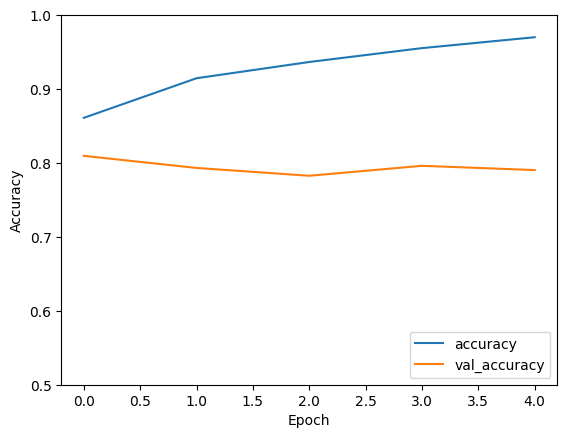

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Numero di classi da classificare
num_classes = 10

# Vettore delle etichette creato come vettore one-shot
y_train = to_categorical(y_train_filtrato,num_classes)
y_test = to_categorical(y_test_filtrato,num_classes)
y_val = to_categorical(y_val_filtrato,num_classes)

# Numero di elementi da utilizzare per aggiornamento pesi
batch_size = 64 #512 #128

# Epoche su cui basare l'apprendimento
epochs = 20 #20 #100

# Definizione degli strati della rete
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(pca_train.n_components_,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Assemblaggio del modello
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Creazione callback x earlystopping 
callback = EarlyStopping(monitor='val_loss', patience=4)

# Esecuzione allenamento e calcolo affidabilità
print("\n - TRAIN - ")
history = model.fit(df_filtrato, y_train,batch_size=batch_size,epochs=epochs,verbose=1, validation_data=(df_filtrato_val, y_val), callbacks=[callback])

print("\n - VALUTAZIONE SU TEST - ")
test_loss, test_acc = model.evaluate(df_filtrato_test,  y_test, verbose=2)

print("\n - GRAFICO Train e Validation - ")
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')